In [1]:
import astropy.units as u
import astropy.constants as const
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

In [2]:
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator

color_map = {
    "green1": "#66c2a5",
    "orange": "#fc8d62",
    "blue": "#8da0cb",
    "pink": "#e78ac3",
    "green2": "#a6d854",
    "yellow": "#ffd92f",
    "brown": "#e5c494",
    "grey": "#b3b3b3",
}

In [3]:
import glob
import os
import sys
sys.path.append('../tools/')

from dust_extinction import calALambda
from spec_to_flux import spec_to_flux, spec_to_mag
from data_binning import data_binning
from visual import rcparams_format

rcparams_format(mpl.rcParams)

## Distance modulus

In [4]:
# SN metadata

z = 0.02736
z_unc = 0.00007
t_max_mjd = 59723.65 # t_0 in salt3
ebv = 0.04
rv = 3.1

# tfl = 58972.46296299994


### IPAC velocity calculator

- $z=0.02736$, $v = cz = 8202.3$ km/s, $v_\mathrm{CMB} = 8346.4$ km/s

### Cosmic flow

- $\Omega_M=0.3$, $h_0=0.7$

In [5]:
cosmo = np.loadtxt('SN2022joj_cosmo.txt')
print('Luminosity distances =', cosmo[6], 'Mpc')

mu = 5 * np.log10(cosmo[6] * 1e6 / 10)
print('Distance modulus = {:.2f}'.format(mu))


Luminosity distances = 114.48 Mpc
Distance modulus = 35.29


## Light curves

In [6]:
import pandas as pd
from astropy.table import Table

In [7]:
joj_ZTF = pd.read_csv('./ZTF22aajijjf_forced_fnu.csv')
joj_ZTF['MJD'] = joj_ZTF['jd'] - 2400000.5
joj_ZTF['phase'] = (joj_ZTF['MJD'] - t_max_mjd) / (1 + z)
joj_ZTF['fnu_microJy'] = joj_ZTF['fnu_microJy'] * (1 + z)
joj_ZTF['fnu_microJy_unc'] = joj_ZTF['fnu_microJy_unc'] * (1 + z)
arg = (joj_ZTF['phase'] <= 150) & (joj_ZTF['phase'] >= -25)
joj_ZTF = joj_ZTF[arg]
joj_ZTF['mag'] = -2.5 * np.log10(joj_ZTF['fnu_microJy'] * 1e-6/3631)
joj_ZTF['mag_err_u'] = -2.5 * np.log10((joj_ZTF['fnu_microJy'] - joj_ZTF['fnu_microJy_unc']) * 1e-6/3631) - joj_ZTF['mag']
joj_ZTF['mag_err_l'] = 2.5 * np.log10((joj_ZTF['fnu_microJy'] + joj_ZTF['fnu_microJy_unc']) * 1e-6/3631) + joj_ZTF['mag']
joj_ZTF_g = joj_ZTF[joj_ZTF['passband'] == 'ZTF_g'].assign(passband='ztfg')
joj_ZTF_r = joj_ZTF[joj_ZTF['passband'] == 'ZTF_r'].assign(passband='ztfr')
joj_ZTF_i = joj_ZTF[joj_ZTF['passband'] == 'ZTF_i'].assign(passband='ztfi')
joj_ZTF = pd.concat([joj_ZTF_g, joj_ZTF_r, joj_ZTF_i])


/Users/chang/miniconda3/envs/astron/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/chang/miniconda3/envs/astron/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/chang/miniconda3/envs/astron/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [8]:
# joj_ZTF = joj_ZTF[~np.isnan(joj_ZTF['mag'])]
joj_ZTF_g = joj_ZTF[joj_ZTF['passband'] == 'ztfg']
joj_ZTF_r = joj_ZTF[joj_ZTF['passband'] == 'ztfr']
joj_ZTF_i = joj_ZTF[joj_ZTF['passband'] == 'ztfi']

## SALT3 fit

In [9]:
joj_SALT = {}
lc = joj_ZTF.copy()
arg = ((lc['MJD'] - t_max_mjd) / (1 + z) <= 50) & ((lc['MJD'] - t_max_mjd) / (1 + z) >= -25)
joj_SALT['time'] = lc['MJD'][arg]
joj_SALT['band'] = lc['passband'][arg]
joj_SALT['flux'] = lc['fnu_microJy'][arg]
joj_SALT['fluxerr'] = lc['fnu_microJy_unc'][arg]
joj_SALT['zp'] = [2.5 * np.log10(3631 * 1e6)] * len(lc[arg])
joj_SALT['zpsys'] = ['ab'] * len(lc[arg])
joj_SALT = Table(joj_SALT)


/Users/chang/miniconda3/envs/astron/lib/python3.10/site-packages/iminuit/util.py:183: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


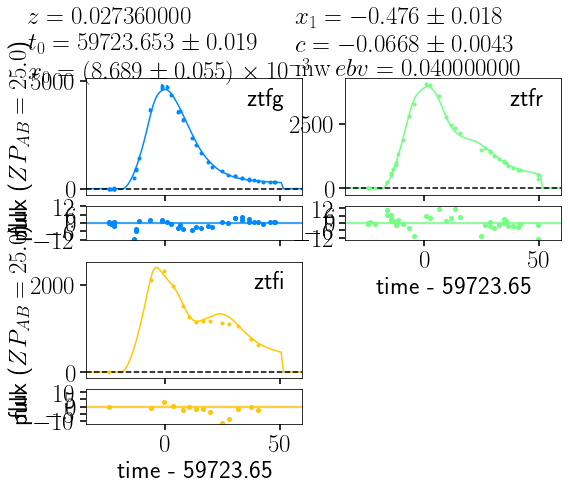

In [10]:
import sncosmo

model = sncosmo.Model(source='salt3', effects=[
                      sncosmo.F99Dust()], effect_names=['mw'], effect_frames=['obs'])
model.set(z=z, mwebv=ebv)

result, fitted_model = sncosmo.fit_lc(
    joj_SALT, model,
    ['t0', 'x0', 'x1', 'c'])

_ = sncosmo.plot_lc(joj_SALT, model=fitted_model, errors=result.errors)

In [11]:
# M_B_max and Delta M(15)
from copy import deepcopy

peakphase_B = fitted_model.source.peakphase('bessellb')
m1 = fitted_model.source.bandmag('bessellb', 'ab', peakphase_B)
m2 = fitted_model.source.bandmag('bessellb', 'ab', peakphase_B + 15)

print('t_max_B = {:.2f}'.format(peakphase_B))
print('delta M_15 = {:.2f}'.format(m2 - m1))

dered_model = deepcopy(fitted_model)
dered_model.set(mwebv=0)
print('B_max = {:.2f}'.format(dered_model.source.bandmag(band="bessellb", phase=peakphase_B, magsys="ab") - mu))
print(
    'B_max - V_max = {:.2f}'.format(dered_model.source.bandmag(band="bessellb", phase=peakphase_B, magsys="ab")
    - dered_model.source.bandmag(band="bessellv", phase=peakphase_B, magsys="ab"))
)


t_max_B = -0.51
delta M_15 = 1.16
B_max = -19.63
B_max - V_max = -0.18


## Early rise

In [12]:
import pymc as pm
import arviz as az

In [13]:
# joj_ZTF_r_rise = joj_ZTF_r[((joj_ZTF_r['MJD'] - t_max_mjd) / (1 + z) <= -10)
#                            & ((joj_ZTF_r['MJD'] - t_max_mjd) / (1 + z) >= -25)]
# MJD_pred = np.linspace(-25, -10, 100) + t_max_mjd
# with pm.Model() as rise_MJD:
#     t_exp = pm.Uniform('t_exp', joj_ZTF_r_rise['MJD'].values[0], joj_ZTF_r_rise['MJD'].values[-1])
#     alpha = pm.Normal('alpha', 2, 1)
#     log_A = pm.Normal('log_A', 1, 1)
#     phase = joj_ZTF_r_rise['MJD'].values - t_exp
#     flux = pm.Deterministic(
#         'flux', 10**log_A * ((phase + np.abs(phase))/2)**alpha)
#     flux_obs = pm.Normal(
#         'flux_obs', flux, joj_ZTF_r_rise['fnu_microJy_unc'].values, observed=joj_ZTF_r_rise['fnu_microJy'].values)
#     flux_pred = pm.Deterministic('flux_pred',
#                                  10**log_A * (((MJD_pred - t_exp) + np.abs(MJD_pred - t_exp))/2)**alpha)
#     trace_MJD = pm.sample(return_inferencedata=True, tune=2000)

In [67]:
# summary = az.summary(trace_MJD, hdi_prob=0.68, var_names=[var for var in trace_MJD.posterior.data_vars if not 'flux' in var])
# summary_pred = az.summary(trace_MJD, hdi_prob=0.68, var_names=[var for var in trace_MJD.posterior.data_vars if 'pred' in var])
# summary

/Users/chang/miniconda3/envs/astron/lib/python3.10/site-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_16%,hdi_84%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,2.351,0.272,2.035,2.561,0.014,0.010,398.0,495.0,1.02
log_A,0.346,0.351,0.104,0.770,0.018,0.013,397.0,494.0,1.02
t_exp,59702.650,0.800,59702.103,59703.640,0.041,0.029,398.0,542.0,1.02


$t_\mathrm{fl} (\mathrm{MJD}) = 59702.65 ^{+0.99}_{-0.55}$

In [14]:
t_fl_mjd = 59702.65
t_fl_mjd_up, t_fl_mjd_lo = 59703.64, 59702.10
rise_time = ((t_max_mjd + peakphase_B) - t_fl_mjd) / (1 + z)
rise_time

19.94211752829478

$t_\mathrm{rise} = 19.94\,\mathrm{days}$

<ErrorbarContainer object of 3 artists>

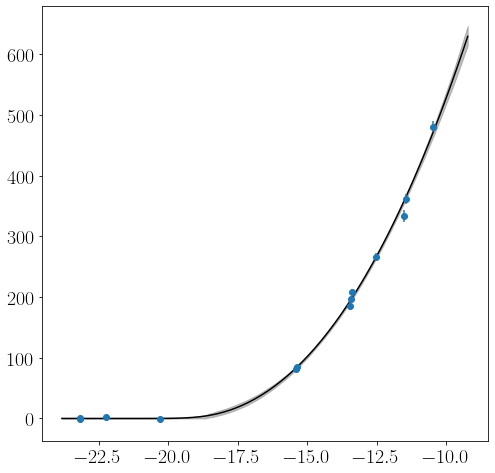

In [65]:
# plt.figure(figsize=(8, 8))
# plt.plot((MJD_pred - t_max_mjd) / (1 + z) - peakphase_B, summary_pred["mean"], color="k")
# plt.fill_between(
#     (MJD_pred - t_max_mjd) / (1 + z) - peakphase_B, summary_pred["hdi_16%"], summary_pred["hdi_84%"], color="0.5", alpha=0.5
# )
# plt.errorbar(
#     (joj_ZTF_r_rise["MJD"].values - t_max_mjd) / (1 + z) - peakphase_B,
#     joj_ZTF_r_rise["fnu_microJy"].values,
#     yerr=joj_ZTF_r_rise["fnu_microJy_unc"].values,
#     fmt="o",
# )
# plt.yscale('log')
# plt.xlim(-17, -10)
# plt.ylim(50, 550)

## Color evolution

In [15]:
# From Bulla, Miller+2020

gr_population = pd.read_csv(
    "color/g_r_Bulla20.txt",
    delim_whitespace=True,
    comment="#",
    names=[
        "SN",
        "t",
        "e_t_min",
        "e_t_max",
        "gr",
        "e_gr_min",
        "e_gr_max",
        "type",
        "marker",
    ],
)

normal_ia = np.where(
    (gr_population.type == "normal*") | (gr_population.type == "normal")
)
over_luminous_ia = np.where(
    (gr_population.type == "91T-like")
    | (gr_population.type == "99aa-like")
    | (gr_population.type == "99aa-like*")
)

print(
    "There are {} normal SNe in this sample".format(
        len(gr_population.iloc[normal_ia].SN.unique())
    )
)

There are 56 normal SNe in this sample


In [16]:
def mag1_mag2(X, Y, bin_size=1, flux=False):
    '''
    calculate the color using multi-band photometry
    
    Parameters
    ----------
    X, Y : array-like
        X-, Y-band photometry
        column 1 - obs time (day)
        column 2 - magnitude/flux
        column 3 - (symmetric) uncertainty
        column 4 & 5 (optional) - (upper & lower) uncertainty
    bin_size : float, default = 1 (day)
        the maximum allowed offset of the obs times for the X-
        and Y-band photometry to calculate the color
    flux : bool, default = False
        whether to estimate the color uncertainty from the uncertainty
        of flux ratio, needs column 4 & 5 from X, Y
    '''
    t1, t2 = X[:, 0], Y[:, 0]
    if not flux:
        mag1, mag2 = X[:, 1], Y[:, 1]
        unc1, unc2 = X[:, 2], Y[:, 2]
        i, j = 0, 0
        T = []
        dmag, Unc = [], []
        while i < len(t1):
            while j < len(t2):
                if t2[j] >= t1[i] + bin_size:
                    break
                if (np.abs(t2[j] - t1[i]) < bin_size):
                    t = (t1[i] / unc1[i]**2 + t2[j] / unc2[j]**2) / (
                        1 / unc1[i]**2 + 1 / unc2[j]**2)
                    mag = (mag1[i] - mag2[j])
                    unc = (unc1[i]**2 + unc2[j]**2)**.5
                    T = np.append(T, t)
                    dmag = np.append(dmag, mag)
                    Unc = np.append(Unc, unc)
                    break
                j += 1
            i += 1
        arg = np.argwhere(Unc < 999).flatten()
        return T[arg], dmag[arg], Unc[arg]
    else:
        f1, f2 = X[:, 1], Y[:, 1]
        f_unc1, f_unc2 = X[:, 2], Y[:, 2]
        i, j = 0, 0
        T = []
        dmag, Unc_u, Unc_l = [], [], []
        while i < len(t1):
            while j < len(t2):
                if t2[j] >= t1[i] + bin_size:
                    break
                if (np.abs(t2[j] - t1[i]) < bin_size):
                    if f1[i] <= f_unc1[i] or f2[j] <= f_unc2[j]:
                        j += 1
                        continue
                    f12 = f1[i] / f2[j]
                    f12unc = f12 * ((f_unc1[i] / f1[i])**2 +
                                    (f_unc2[j] / f2[j])**2)**.5
                    t = (t1[i] / f_unc1[i]**2 + t2[j] / f_unc2[j]**2) / (
                        1 / f_unc1[i]**2 + 1 / f_unc2[j]**2)
                    T = np.append(T, t)
                    dmag = np.append(dmag, -2.5 * np.log10(f12))
                    Unc_u = np.append(Unc_u,
                                      -2.5 * np.log10(f12 / (f12 + f12unc)))
                    Unc_l = np.append(Unc_l, -2.5 * np.log10(
                        (f12 - f12unc) / f12))
                    break
                j += 1
            i += 1
        arg = np.argwhere(Unc_l < 999).flatten()
        return T[arg], dmag[arg], [Unc_u[arg], Unc_l[arg]]

In [17]:
# SN 2022joj
leff_g = 4722.74  # AA
leff_r = 6339.61  # AA
leff_i = 7886.13  # AA
rv = 3.1
ebv = 0.04

t_exp = -((t_max_mjd + peakphase_B) - t_fl_mjd) / (1 + z)
t_exp_lo = -((t_max_mjd + peakphase_B) - t_fl_mjd_lo) / (1 + z)
t_exp_up = -((t_max_mjd + peakphase_B) - t_fl_mjd_up) / (1 + z)

g_r_cor = calALambda(leff_g, EBV=ebv, RV=rv) - calALambda(leff_r, EBV=ebv, RV=rv)
r_i_cor = calALambda(leff_r, EBV=ebv, RV=rv) - calALambda(leff_i, EBV=ebv, RV=rv)

ZTFg = np.array(
    [joj_ZTF_g["phase"], joj_ZTF_g["fnu_microJy"], joj_ZTF_g["fnu_microJy_unc"]]
).T
ZTFr = np.array(
    [joj_ZTF_r["phase"], joj_ZTF_r["fnu_microJy"], joj_ZTF_r["fnu_microJy_unc"]]
).T
ZTFi = np.array(
    [joj_ZTF_i["phase"], joj_ZTF_i["fnu_microJy"], joj_ZTF_i["fnu_microJy_unc"]]
).T

for lc in [ZTFg, ZTFr, ZTFi]:
    idx = lc[:, 1] < lc[:, 2] * 2
    lc[idx, 1] = lc[idx, 2] * 3
    lc[idx, 2] = 9999

phase_joj, g_r_joj, g_r_unc_joj = mag1_mag2(ZTFg, ZTFr, flux=True, bin_size=0.5)
g_r_joj = g_r_joj - g_r_cor
# print(phase_joj)
# K_corr = np.array([-0.1953523,  -0.18842639, -0.18842264, -0.17979563, -0.13118341, -0.07866182,
#  -0.07784923, -0.09957032, -0.14747028, -0.16704749, -0.18622967, -0.23207121,
#  -0.21986836, -0.21986175, -0.19807829, -0.19807533, -0.19169122, -0.18660783,
#  -0.17411484, -0.17234143, -0.16950744, -0.15789981])

In [20]:
# SN2013bh
with open("./SN2013bh/SN2013bh_lc.dat") as f:
    lines = f.readlines()

z_bh = float(lines[0].split("=")[-1])
ebv_bh = float(lines[1].split("=")[-1])
mu_bh = float(lines[2].split("=")[-1].split("+/-")[0])
t_max_mjd_bh = float(lines[3].split("=")[-1].split(")")[0])
mjd_bh = np.array([float(i) for i in lines[5].split()]) + 2456000 - 2400000.5
# phase_bh = (mjd_bh - t_max_mjd_bh) / (1 + z_bh)

t_fl_bh = (370.02 + 375.02) / 2 + 2456000 - 2400000.5
# phase_fl_bh = (mjd_bh - t_fl_bh) / (1 + z_bh)

dat = np.loadtxt("./SN2013bh/SN2013bh_lc_Kcorr.dat")
phase_bh = dat[:, 0]
g_bh, g_bh_err = dat[:, 1], dat[:, 3]
r_bh, r_bh_err = dat[:, 5], dat[:, 6]

g_r_bh = mag1_mag2(
    np.array([phase_bh, g_bh, g_bh_err]).T, np.array([phase_bh, r_bh, r_bh_err]).T
)

ZTF18aasdted normal
ZTF18aaxcntm normal
ZTF18aaxdrjn normal
ZTF18aaxsioa normal
ZTF18aayjvve normal
ZTF18abauprj over_luminous
ZTF18abcflnz normal
ZTF18abcrxoj normal
ZTF18abeecwe normal
ZTF18abfhryc normal
ZTF18abgmcmv over_luminous
ZTF18abkhcrj normal
ZTF18abkhcwl normal
ZTF18abpaywm normal


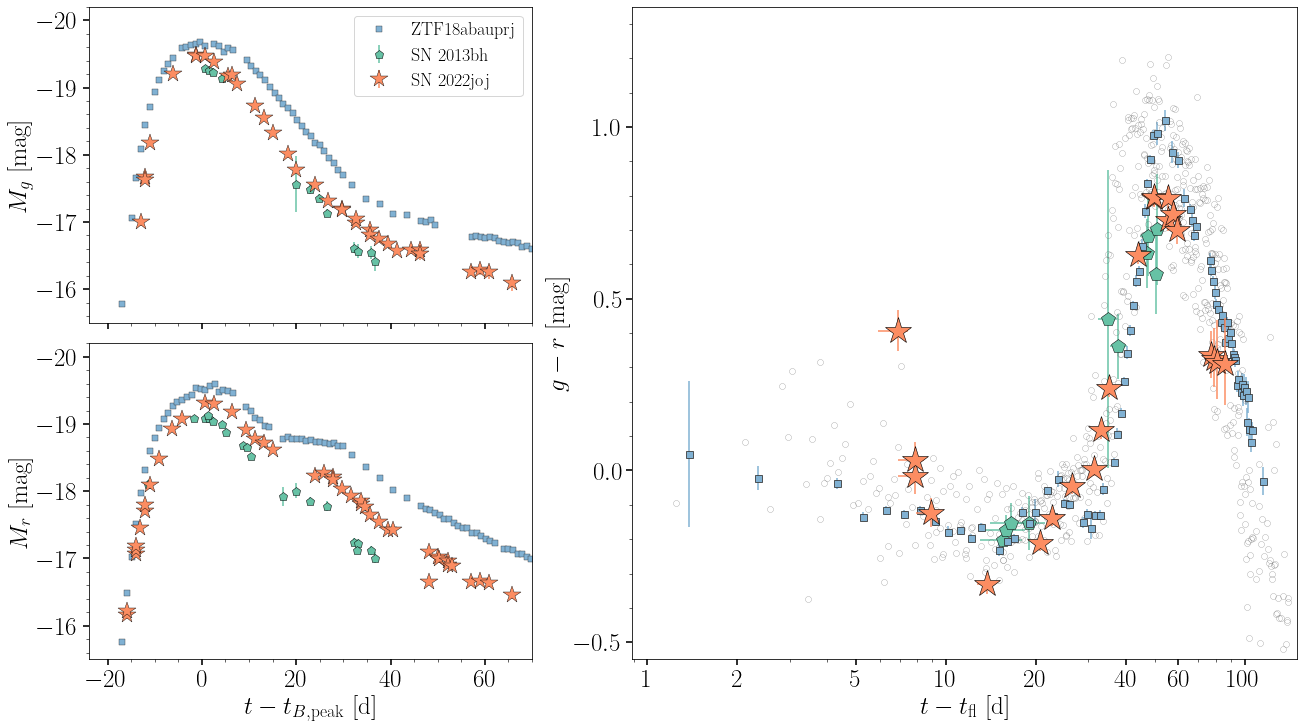

In [44]:
f = plt.figure(figsize=(18, 10), constrained_layout=True)
widths = [6, 9]
heights = [3.5, 3.5]
gs = f.add_gridspec(ncols=2, nrows=2, width_ratios=widths, height_ratios=heights)
# g light curves
ax1 = f.add_subplot(gs[0, 0])
# r light curves
ax2 = f.add_subplot(gs[1, 0])
# g - r
ax3 = f.add_subplot(gs[:, 1])

col_91T = color_map["blue"]
col_13bh = color_map["green1"]
col_22joj = color_map["orange"]

# light curves
# 11fe
# ax1.errorbar(fe_g_syn[:, 0],
#              fe_g_syn[:, 1],
#              yerr=fe_g_syn[:, 2],
#              fmt='d',
#              markersize=9,
#              markeredgecolor='k',
#              markeredgewidth=.5,
#              color=col_91T,
#              label='$\mathrm{SN\ 2011fe}$')
# ax2.errorbar(fe_r_syn[:, 0],
#              fe_r_syn[:, 1],
#              yerr=fe_r_syn[:, 2],
#              fmt='d',
#              markersize=9,
#              markeredgecolor='k',
#              markeredgewidth=.5,
#              color=col_91T)

# 13bh
ax1.errorbar(
    phase_bh,
    g_bh,
    yerr=g_bh_err,
    fmt="p",
    markersize=9,
    markeredgecolor="k",
    markeredgewidth=0.5,
    color=col_13bh,
    label="$\mathrm{SN\ 2013bh}$",
)
ax2.errorbar(
    phase_bh,
    r_bh,
    yerr=r_bh_err,
    fmt="p",
    markersize=9,
    markeredgecolor="k",
    markeredgewidth=0.5,
    color=col_13bh,
)

for x, ax in zip([joj_ZTF_g, joj_ZTF_r], [ax1, ax2]):
    # last non-detection
    last_non_det = np.argwhere(
        (x["fnu_microJy"].values <= x["fnu_microJy_unc"].values * 2)
        & (x["phase"].values < -15)
    ).ravel()[-1]
    lim_non_det = -2.5 * np.log10(
        x["fnu_microJy_unc"].values[last_non_det] * 5 * 1e-6 / 3631
    )
    ax.arrow(
        x=x["phase"].values[last_non_det],
        y=lim_non_det - mu - 0.3,
        dx=0,
        dy=0.3,
        width=0.08,
        head_width=1,
        head_length=0.1,
        length_includes_head=True,
        color=col_22joj,
    )
    ax.errorbar(
        x["phase"],
        x["mag"] - mu,
        yerr=np.array([x["mag_err_l"].values, x["mag_err_u"].values]),
        fmt="*",
        markersize=18,
        markeredgecolor="k",
        markeredgewidth=0.4,
        color=col_22joj,
        label="$\mathrm{SN\ 2022joj}$",
    )

    ax.set_xlim(-24, 70)

ax1.xaxis.set_ticklabels([])
ax1.set_ylabel(r"$M_g\ \mathrm{[mag]}$")
ax2.set_ylabel(r"$M_r\ \mathrm{[mag]}$")
ax2.set_xlabel(r"$t-t_{B,\mathrm{peak}}\ [\mathrm{d}]$")

ax2.set_ylim(-20.2, -15.5)
ax1.set_ylim(-20.2, -15.5)
ax1.invert_yaxis()
ax2.invert_yaxis()

# g-r color
# the four individuals
# ax3.errorbar(fe_g_r_syn[:, 0],
#              fe_g_r_syn[:, 1],
#              yerr=fe_g_r_syn[:, 2],
#              fmt='d',
#              markersize=9,
#              markeredgecolor='k',
#              markeredgewidth=.5,
#              color=col_91T)
# ax3.errorbar(dT_jhr,
#              dmag_jhr,
#              yerr=Unc_jhr,
#              fmt='p',
#              markersize=10,
#              markeredgecolor='k',
#              markeredgewidth=.5,
#              color=col_13bh)
ax3.errorbar(
    phase_joj + rise_time,
    g_r_joj,
    xerr=[[t_fl_mjd_up - t_fl_mjd], [t_fl_mjd - t_fl_mjd_lo]],
    yerr=g_r_unc_joj,
    fmt="*",
    markersize=28,
    markeredgecolor="k",
    markeredgewidth=0.6,
    color=col_22joj,
    zorder=100,
)
ax3.errorbar(
    g_r_bh[0] + (t_max_mjd_bh - t_fl_bh) / (1 + z),
    g_r_bh[1],
    xerr=np.ones_like(g_r_bh[0]) * 2.5,
    yerr=g_r_bh[2],
    fmt="p",
    markersize=15,
    markeredgecolor="k",
    markeredgewidth=0.5,
    color=col_13bh,
)

# peak time
# ax3.plot([(tp - tfl) / (1 + z), (tp - tfl) / (1 + z)], [-0.7, -0.4],
#          color=col_22joj,
#          alpha=.9,
#          zorder=-10)

# ZTF sample
# K-corrections
# ax3.plot(
#     gr_population.iloc[normal_ia].t.values,
#     gr_population.iloc[normal_ia].gr.values,
#     "o",
#     color="None",
#     mec="0.4",
#     mew=0.3,
#     ms=6,
#     alpha=0.5,
# )
# ax3.plot(
#     gr_population.iloc[over_luminous_ia].t.values,
#     gr_population.iloc[over_luminous_ia].gr.values,
#     "s",
#     color="#80b1d3",
#     mec="k",
#     mew=0.5,
#     ms=6,
#     alpha=.5,
# )


# No K-corrections
ebv_sbv = pd.read_csv("./color/early18ia/ebv_sbv.txt", sep=" ")
lcs = glob.glob("./color/early18ia/*dat")
lcs.sort()
t_tfl_list = fits.getdata("./color/Bulla20.fit")

for lc in lcs:
    name = lc.split("/")[-1].split(".")[0]
    if (name in gr_population.iloc[over_luminous_ia].SN.unique()) or (
        name in gr_population.iloc[normal_ia].SN.unique()
    ):
        t_tfl = t_tfl_list["t-tfl"][t_tfl_list["ZTF"] == name]
        if t_tfl_list["z"][t_tfl_list["ZTF"] == name] >= 0.05:
            continue
        raw = pd.read_csv(lc, sep=" ")
        lc_g0 = np.array(raw)[:, :-1][raw["fid"] == 1]  # determine the first detection
        lc_r0 = np.array(raw)[:, :-1][raw["fid"] == 2]
        lc_g = np.array(raw)[:, :-1][
            (raw["fid"] == 1) & (raw["mag_unc"] < 0.2)
        ]  # SNR > 5
        lc_r = np.array(raw)[:, :-1][(raw["fid"] == 2) & (raw["mag_unc"] < 0.2)]
        g_r0 = mag1_mag2(lc_g0, lc_r0, bin_size=.3)
        g_r = mag1_mag2(lc_g, lc_r, bin_size=.3)
        t_offset = t_tfl - g_r0[0][0]
        ebv = np.array(ebv_sbv["ebv"])[ebv_sbv["sn"] == name][0]
        if name in gr_population.iloc[over_luminous_ia].SN.unique():
            print(name, "over_luminous")
            if lc_g0[:, 1].min() - calALambda(wv=leff_g, EBV=ebv, RV=3.1) > -20:
                ax1.plot(
                    lc_g0[:, 0],
                    lc_g0[:, 1] - calALambda(wv=leff_g, EBV=ebv, RV=3.1),
                    "s",
                    color="#80b1d3",
                    mec="0.2",
                    mew=0.4,
                    ms=6,
                    label=r"$\mathrm{" + name + r"}$",
                )
                ax2.plot(
                    lc_r0[:, 0],
                    lc_r0[:, 1] - calALambda(wv=leff_r, EBV=ebv, RV=3.1),
                    "s",
                    color="#80b1d3",
                    mec="0.2",
                    mew=0.4,
                    ms=6,
                )
                ax3.errorbar(
                    g_r[0] + t_offset,
                    g_r[1]
                    - (
                        calALambda(wv=leff_g, EBV=ebv, RV=3.1)
                        - calALambda(wv=leff_r, EBV=ebv, RV=3.1)
                    ),
                    fmt="s",
                    yerr=g_r[2],
                    color="#80b1d3",
                    mec="0.2",
                    mew=0.8,
                    ms=7,
                )
        else:
            print(name, "normal")
            ax3.plot(
                g_r[0] + t_offset,
                g_r[1]
                - (
                    calALambda(wv=leff_g, EBV=ebv, RV=3.1)
                    - calALambda(wv=leff_r, EBV=ebv, RV=3.1)
                ),
                "o",
                color="None",
                mec="0.4",
                mew=0.3,
                ms=6,
                alpha=0.8,
            )
ax3.set_ylim(-0.55, 1.35)
ax3.set_xlim(0.89, 150)
ax3.set_ylabel("$g-r\ \mathrm{[mag]}$")
ax3.set_xlabel("$t-t_\mathrm{fl}\ [\mathrm{d}]$")
ax3.set_xscale("log")
ax1.legend(prop={"size": 18})

for ax in [ax1, ax2]:
    ax.xaxis.set_minor_locator(MultipleLocator(5))
    ax.xaxis.set_major_locator(MultipleLocator(20))
    ax.yaxis.set_minor_locator(MultipleLocator(0.2))
    ax.yaxis.set_major_locator(MultipleLocator(1))
ax3.yaxis.set_major_locator(MultipleLocator(0.5))
ax3.yaxis.set_minor_locator(MultipleLocator(0.1))

xticks = [1, 2, 5, 10, 20, 40, 60, 100]
ax3.set_xticks(xticks)
ax3.set_xticklabels([f'${tick}$' for tick in xticks])

plt.savefig("../paper/figures/photometry.pdf", bbox_inches="tight")